<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/Autoencoder_YRBSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoders and Data Quality for Tabular Data**

In [1]:
!rm -rf autoencoders_census
!git clone https://github.com/ipeirotis/autoencoders_census.git
%cd autoencoders_census

Cloning into 'autoencoders_census'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 202 (delta 48), reused 0 (delta 0), pack-reused 123
Receiving objects: 100% (202/202), 3.89 MiB | 9.56 MiB/s, done.
Resolving deltas: 100% (114/114), done.
/content/autoencoders_census


In [2]:
from google.colab import auth

# Login using the account that has access to the Google project
# in order to access the resources for the project
auth.authenticate_user()

In [3]:
# This code imports the DataTransformer object from
# the notebook pandas2vector.ipynb
!pip install -q import_ipynb keras-tuner
import import_ipynb
from pandas2vector import Table2Vector
from data_loader import DataLoader
from autoencoder import AutoencoderModel

importing Jupyter notebook from pandas2vector.ipynb
importing Jupyter notebook from data_loader.ipynb
importing Jupyter notebook from autoencoder.ipynb


# Data Source

The used data stems from the Youth Risk Behavior Surveillance System by CDC (Centers for Disease Control and Prevention). It includes data on a set of surveys that track behaviors that can lead to poor health in students grades 9 through 12. [Here](https://www.cdc.gov/healthyyouth/data/yrbs/data.htm) is the link to the dataset.

Note: The dataset is updated every two years. We use the 2017 version of the national high school YRBS dataset.

## Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from matplotlib.offsetbox import TransformedBbox

In [6]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from numpy.random import uniform
from numpy.random import seed

In [7]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K
from keras import Model

In [8]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras

# Load Original Dataset

In [9]:
# Data Source
data_loader = DataLoader()
original_df = data_loader.load_original_data()
project_data, var_types = data_loader.prepare_original_dataset(original_df)

print(f"Shape of original data: {original_df.shape}")
print(f"Shape of data set we analyze: {project_data.shape}")

# Vectorizing the data set

In [12]:
# Data Transformation
vectorizer = Table2Vector(var_types)

# Vectorizing *without* indicator variables for missingness
vectorized_df = vectorizer.vectorize_table(project_data)

vectorized_df.shape

In [14]:
assert( vectorizer.tabularize_vector(vectorized_df).shape == project_data.shape )

# Autoencoder loading

In [15]:
from tensorflow.keras.models import load_model
import gcsfs

# Define the path to the file on GCS
gcs_model_path = "gs://autoencoder_census_models/best_parameters_autoencoder.h5"

# Define the local path where the model will be downloaded
local_model_path = "best_parameters_autoencoder.h5"

# Create a GCS filesystem object using your project ID
fs = gcsfs.GCSFileSystem(project='Your-Project-ID')

# Download the model file from GCS
with fs.open(gcs_model_path, 'rb') as gcs_file:
    with open(local_model_path, 'wb') as local_file:
        local_file.write(gcs_file.read())

# Load the model from the local file
model = load_model(local_model_path)


## Making Predictions and Filling in the Missing Values


In [16]:
import numpy as np

# Fill the missing values with some initial guess. Here, the median of each column is used.
filled = vectorized_df.fillna(vectorized_df.median())

# Define a condition for stopping the iteration
epsilon = 1e-4
old_filled = None

while old_filled is None or np.abs(filled - old_filled).sum().sum() > epsilon:
  # Save the old filled DataFrame for convergence check
  old_filled = filled.copy()

  # Run the data through the autoencoder, which will return a complete version of the data.
  predicted = model.predict(filled)

  # Replace the initially guessed values in the original data with the corresponding values from the autoencoder's output. But keep the observed values unchanged.
  mask = vectorized_df.isna()
  filled[mask] = np.where(mask, predicted, filled)


462/462 [==============================] - 1s 2ms/step


In [17]:
filled

,weight,stheight,stweight,bmi,bmipct,age__12 years old or younger,age__13 years old,age__14 years old,age__15 years old,age__16 years old,...,sunburn__2 times,sunburn__3 times,sunburn__4 times,sunburn__5 or more times,difficulty_concentrating__No,difficulty_concentrating__Yes,how_well_speak_English__Not at all,how_well_speak_English__Not well,how_well_speak_English__Very well,how_well_speak_English__Well
0,0.508875,0.427485,0.213812,0.096920,0.564056,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.347927,0.410195,0.225161,0.110746,0.708790,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.142144,0.458250,0.263093,0.105426,0.645022,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.161873,0.550312,0.250010,0.085643,0.579082,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.415955,0.500845,0.229304,0.107141,0.582910,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14760,0.018136,0.510233,0.263420,0.091801,0.663649,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14761,0.030378,0.562238,0.275074,0.087894,0.635913,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14762,0.021987,0.562486,0.276537,0.087851,0.640319,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14763,0.087971,0.577465,0.188926,0.082226,0.089027,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
vectorized_df.shape

(14765, 563)

In [19]:
filled.shape

(14765, 563)

In [20]:
# data_transformer.reverse_transform_dataframe(filled)


In [21]:



# Repeat steps 2 and 3 for a number of times or until the changes in the imputed values become small enough.

## Examine Training Output Statistics

Visualize the empirical distribution function of the latent representation obtained from the encoder model.

In [22]:
model.predict(filled)[0,:]

462/462 [==============================] - 1s 3ms/step


array([ 1.99700624e-01,  4.27484781e-01,  2.13811934e-01,  9.69200358e-02,
        5.64055562e-01,  4.43466287e-03, -4.20410559e-03, -2.01404095e-03,
        1.53152600e-01,  3.07254314e-01,  3.49727422e-01,  2.07994178e-01,
        9.51935410e-01,  4.57863212e-02,  2.70914644e-01,  3.41578126e-01,
        3.46510887e-01,  4.23600525e-02,  7.91441202e-02,  2.22417831e-01,
        3.19445610e-01,  3.57522786e-01, -6.56832894e-03,  3.65168080e-02,
        2.23508418e-01,  3.19508344e-01,  2.18268037e-02, -2.27922238e-02,
        3.57698858e-01,  9.58205462e-01,  3.94323319e-02,  8.28429043e-01,
        1.71688735e-01,  8.33206549e-02,  6.71191067e-02,  8.47173154e-01,
        4.15956005e-02, -7.65386224e-03,  4.84873019e-02,  9.54597533e-01,
       -1.15543574e-01,  7.98698738e-02,  6.51261061e-02,  8.46617222e-01,
        3.91992368e-02,  8.45277488e-01,  1.37085825e-01,  3.98137942e-02,
        4.63846698e-02, -1.14929169e-01,  8.90836775e-01,  9.84020606e-02,
       -1.15753651e-01,  

Assess the quality of the autoencoder's reconstruction by calculating the Mean Absolute Error (MAE) between the reconstructed data and the original data.

462/462 [==============================] - 1s 2ms/step


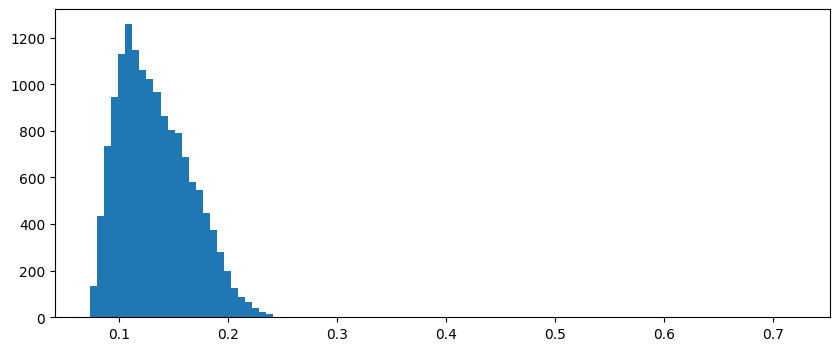

In [23]:
plt.figure(figsize=(10, 4))
# reconstruct the original data
normal_reconstructions = model.predict(filled)
# compute the Mean Absolute Error between the reconstructed data and the original data
normal_loss = tf.losses.mae(normal_reconstructions,filled)
plt.hist(normal_loss, bins=100)
plt.show()

The threshold value based on the mean and standard deviation of the reconstruction error. This threshold provides a reference point for distinguishing between normal reconstruction errors and potential outliers.

In [24]:
threshold = np.mean(normal_loss) + 2*np.std(normal_loss)
print(threshold)

0.20373582567727733


Visualize the distribution of the reconstruction errors and highlight the threshold for identifying outliers in the reconstruction error.

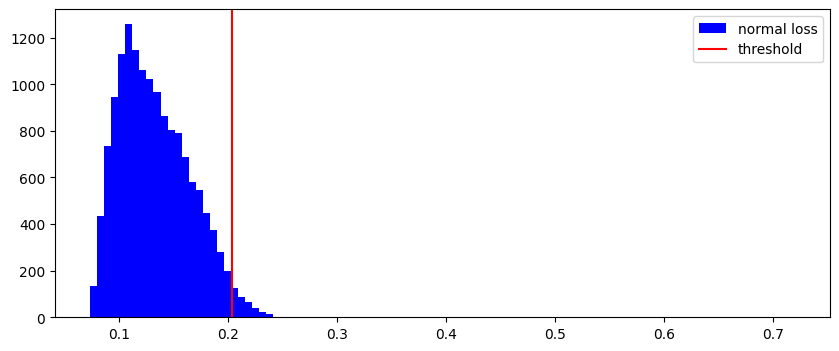

In [25]:
plt.figure(figsize=(10, 4))
plt.hist(normal_loss, bins=100, color='b', label="normal loss")
# add a vertical line to the plot at the position of the threshold value
plt.axvline(threshold, color='r', label="threshold")
plt.legend()
plt.show()

In [26]:
normal_loss

<tf.Tensor: shape=(14765,), dtype=float64, numpy=
array([0.15560631, 0.12936896, 0.18887115, ..., 0.16091885, 0.09593099,
       0.15092953])>

In [27]:
reconstructed_error_df = pd.DataFrame()
reconstructed_error_df['Reconstructed_Error'] = normal_loss


# Create a GCS filesystem object
fs = gcsfs.GCSFileSystem(project='autoencoder-census')

# Define the path to the file on GCS
gcs_path = "gs://autoencoder_census_models/data_with_reconstructed_errors.csv"

# Save the DataFrame to GCS
with fs.open(gcs_path, 'w') as gcs_file:
    reconstructed_error_df.to_csv(gcs_file)

reconstructed_error_df.head()

,Reconstructed_Error
0,0.155606
1,0.129369
2,0.188871
3,0.193907
4,0.097630


Obtain the indices in descending order of the reconstruction errors.

In [28]:
sorted_indices = np.argsort(normal_loss)[::-1]

Identify and extract a subset of samples from the original dataset that have the 100 highest reconstruction errors and have reconstruction errors exceeding the threshold value.

In [29]:

k = 100  # Number of samples to select
samples_with_high_error = vectorized_df.iloc[sorted_indices[:k]]
samples_with_high_error.head()

,weight,stheight,stweight,bmi,bmipct,age__12 years old or younger,age__13 years old,age__14 years old,age__15 years old,age__16 years old,...,sunburn__2 times,sunburn__3 times,sunburn__4 times,sunburn__5 or more times,difficulty_concentrating__No,difficulty_concentrating__Yes,how_well_speak_English__Not at all,how_well_speak_English__Not well,how_well_speak_English__Very well,how_well_speak_English__Well
7504,0.213765,0.281690,0.113368,0.083460,0.332900,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
77,0.029797,NaN,NaN,0.303422,NaN,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6014,0.018889,0.605634,0.377916,0.124438,0.927178,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1203,0.399776,0.507042,0.316842,0.119650,0.935881,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
11426,0.037800,0.577465,0.313958,0.112084,0.840852,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [30]:
# Find indices of tuples with reconstruction values larger than the threshold
anomaly_indices = np.where(normal_loss > threshold)[0]

# Select the corresponding tuples from the original data
anomaly_tuples = vectorized_df.iloc[anomaly_indices]

# Print the anomaly tuples
anomaly_tuples.head()


,weight,stheight,stweight,bmi,bmipct,age__12 years old or younger,age__13 years old,age__14 years old,age__15 years old,age__16 years old,...,sunburn__2 times,sunburn__3 times,sunburn__4 times,sunburn__5 or more times,difficulty_concentrating__No,difficulty_concentrating__Yes,how_well_speak_English__Not at all,how_well_speak_English__Not well,how_well_speak_English__Very well,how_well_speak_English__Well
12,0.211872,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
15,0.043351,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
29,0.638196,NaN,NaN,0.157129,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
38,0.220499,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
44,0.124223,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [31]:
anomaly_tuples.shape

(333, 563)

Reconstruct the transformed data using the trained autoencoder model and get the combined dataframe of the original transformed data with its reconstructed version.

In [32]:

reconstructed_data = model.predict(filled)

reconstructed_df = pd.DataFrame(reconstructed_data, columns=vectorized_df.columns)

combined_df = pd.concat([vectorized_df, reconstructed_df], axis=1)
combined_df.head()

462/462 [==============================] - 1s 2ms/step


,weight,stheight,stweight,bmi,bmipct,age__12 years old or younger,age__13 years old,age__14 years old,age__15 years old,age__16 years old,...,sunburn__2 times,sunburn__3 times,sunburn__4 times,sunburn__5 or more times,difficulty_concentrating__No,difficulty_concentrating__Yes,how_well_speak_English__Not at all,how_well_speak_English__Not well,how_well_speak_English__Very well,how_well_speak_English__Well
0,0.508875,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.147096,0.098379,0.071207,0.049928,0.567217,0.366660,0.018350,-0.025449,0.870585,0.059537
1,0.347927,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.128138,0.064585,0.072525,0.032455,0.388167,0.585639,0.003777,-0.024303,0.809347,0.157729
2,0.142144,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.191621,0.105011,0.069106,0.061737,0.351650,0.504581,0.010660,-0.019433,0.775505,0.081296
3,0.161873,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.193031,0.162390,0.076193,0.191779,0.520659,0.400607,0.022897,-0.001537,0.772647,0.131996
4,0.415955,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.102310,0.087669,0.064204,0.026224,0.683748,0.190121,0.008926,-0.014248,0.735172,0.116224


In [33]:
reconstructed_data1 = model.predict(vectorized_df)
reconstructed_df1 = pd.DataFrame(reconstructed_data, columns=vectorized_df.columns)
columns_to_modify = ["weight","stheight","stweight","bmi","bmipct"]
vectorized_df[columns_to_modify] = vectorized_df[columns_to_modify].replace(0, np.nan)

reconstructed_df1.head()

462/462 [==============================] - 1s 2ms/step


,weight,stheight,stweight,bmi,bmipct,age__12 years old or younger,age__13 years old,age__14 years old,age__15 years old,age__16 years old,...,sunburn__2 times,sunburn__3 times,sunburn__4 times,sunburn__5 or more times,difficulty_concentrating__No,difficulty_concentrating__Yes,how_well_speak_English__Not at all,how_well_speak_English__Not well,how_well_speak_English__Very well,how_well_speak_English__Well
0,0.199701,0.427485,0.213812,0.096920,0.564056,0.004435,-0.004204,-0.002014,0.153153,0.307254,...,0.147096,0.098379,0.071207,0.049928,0.567217,0.366660,0.018350,-0.025449,0.870585,0.059537
1,0.212557,0.410195,0.225161,0.110746,0.708790,0.001296,0.005757,0.247888,0.342647,0.256104,...,0.128138,0.064585,0.072525,0.032455,0.388167,0.585639,0.003777,-0.024303,0.809347,0.157729
2,0.239525,0.458250,0.263093,0.105426,0.645022,0.001197,-0.001693,0.039416,0.170175,0.295288,...,0.191621,0.105011,0.069106,0.061737,0.351650,0.504581,0.010660,-0.019433,0.775505,0.081296
3,0.264630,0.550312,0.250010,0.085643,0.579082,-0.006418,0.011404,0.015053,0.070923,0.312024,...,0.193031,0.162390,0.076193,0.191779,0.520659,0.400607,0.022897,-0.001537,0.772647,0.131996
4,0.209173,0.500845,0.229304,0.107141,0.582910,0.011145,0.005533,0.234751,0.360343,0.240428,...,0.102310,0.087669,0.064204,0.026224,0.683748,0.190121,0.008926,-0.014248,0.735172,0.116224


Calculate the cost standardization and map reconstructed binary values to categories.

\#1 approach for getting cost values:

In [34]:
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in vectorized_df.columns.values if c not in numeric_vars]

cost = {}
mapped_categories = {}

for column in vectorized_df[categorical_vars]:
  probability = vectorized_df[column].mean(axis=0)
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)

  cost[column] = cost_value

for column, cost in cost.items():
    # Map the reconstructed values to categories based on the threshold
    mapped_categories[column] = (reconstructed_df[column] > cost).astype(int)

In [35]:
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in vectorized_df.columns.values if c not in numeric_vars]

cost1 = {}
mapped_categories1 = {}

for column in vectorized_df[categorical_vars]:
  probability = vectorized_df[column].mean(axis=0)
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)

  cost1[column] = cost_value

for column, cost in cost1.items():
    # Map the reconstructed values to categories based on the threshold
    mapped_categories1[column] = (reconstructed_df1[column] > cost).astype(int)

Evaluate the performance of the reconstructed categories compared to the original dataset. A higher AUC score indicates better performance in distinguishing different instances.

In [36]:
auc_scores = {}

for column in mapped_categories:

    mapped_values = mapped_categories[column]
    true_labels = vectorized_df[column]

    fpr, tpr, _ = roc_curve(true_labels, mapped_values)
    roc_auc = auc(fpr, tpr)

    auc_scores[column] = roc_auc

auc_scores

{'age__12 years old or younger': 0.5,
 'age__13 years old': 0.5,
 'age__14 years old': 0.6815179811447349,
 'age__15 years old': 0.5,
 'age__16 years old': 0.5001350975042187,
 'age__17 years old': 0.5002201499442835,
 'age__18 years old or older': 0.5857230905769644,
 'sex__Female': 0.5554924353597862,
 'sex__Male': 0.5913247240361125,
 'grade__10th': 0.5004977375565611,
 'grade__11th': 0.5052594776618622,
 'grade__12th': 0.5150627422620665,
 'grade__9th': 0.5411691046640346,
 'Hispanic_or_Latino__All other races': 0.5756915855775939,
 'Hispanic_or_Latino__Black or African American': 0.554216418164665,
 'Hispanic_or_Latino__Hispanic/Latino': 0.5433282489068458,
 'Hispanic_or_Latino__White': 0.5040481245951621,
 'race__Am Indian / Alaska Native': 0.5,
 'race__Asian': 0.5,
 'race__Black or African American': 0.5529448631664227,
 'race__Hispanic/Latino': 0.5442617502018505,
 'race__Multiple - Non-Hispanic': 0.5,
 'race__Native Hawaiian/other PI': 0.5,
 'race__White': 0.5040481245951621,


In [37]:
from sklearn.metrics import confusion_matrix

num_categories = len(categorical_vars)
confusion_matrices = {}

for column in categorical_vars:
    true_values = vectorized_df[column].astype(int)
    predicted_values = mapped_categories[column]

    cm = confusion_matrix(true_values, predicted_values)

    confusion_matrices[column] = cm

for column, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(cm)
    print()

Confusion Matrix for age__12 years old or younger:
[[14706     0]
 [   59     0]]

Confusion Matrix for age__13 years old:
[[14743     0]
 [   22     0]]

Confusion Matrix for age__14 years old:
[[7489 5354]
 [ 423 1499]]

Confusion Matrix for age__15 years old:
[[    0 11179]
 [    0  3586]]

Confusion Matrix for age__16 years old:
[[    9 11068]
 [    2  3686]]

Confusion Matrix for age__17 years old:
[[    8 11146]
 [    1  3610]]

Confusion Matrix for age__18 years old or older:
[[3841 9128]
 [ 224 1572]]

Confusion Matrix for sex__Female:
[[ 814 6425]
 [  11 7515]]

Confusion Matrix for sex__Male:
[[1457 6196]
 [  55 7057]]

Confusion Matrix for grade__10th:
[[   11 11039]
 [    0  3715]]

Confusion Matrix for grade__11th:
[[  198 10965]
 [   26  3576]]

Confusion Matrix for grade__12th:
[[  427 10955]
 [   25  3358]]

Confusion Matrix for grade__9th:
[[1269 9575]
 [ 136 3785]]

Confusion Matrix for Hispanic_or_Latino__All other races:
[[7239 5802]
 [ 696 1028]]

Confusion Matrix 

In [38]:
merged_df = (pd.DataFrame(mapped_categories)).merge(reconstructed_df[numeric_vars], left_index = True, right_index = True)
merged_df.head(10)

,age__12 years old or younger,age__13 years old,age__14 years old,age__15 years old,age__16 years old,age__17 years old,age__18 years old or older,sex__Female,sex__Male,grade__10th,...,difficulty_concentrating__Yes,how_well_speak_English__Not at all,how_well_speak_English__Not well,how_well_speak_English__Very well,how_well_speak_English__Well,weight,stheight,stweight,bmi,bmipct
0,0,0,0,1,1,1,1,1,1,1,...,1,0,0,1,0,0.199701,0.427485,0.213812,0.096920,0.564056
1,0,0,1,1,1,1,0,1,0,1,...,1,0,0,1,1,0.212557,0.410195,0.225161,0.110746,0.708790
2,0,0,0,1,1,1,1,1,1,1,...,1,0,0,1,0,0.239525,0.458250,0.263093,0.105426,0.645022
3,0,0,0,1,1,1,1,1,1,1,...,1,0,0,1,1,0.264630,0.550312,0.250010,0.085643,0.579082
4,0,0,1,1,1,1,0,1,1,1,...,1,0,0,1,1,0.209173,0.500845,0.229304,0.107141,0.582910
5,0,0,0,1,1,1,1,1,1,1,...,1,0,0,1,0,0.217796,0.470106,0.270638,0.109159,0.632847
6,0,0,0,1,1,1,1,1,1,1,...,1,0,0,1,1,0.262373,0.627755,0.288296,0.091446,0.586710
7,0,0,0,1,1,1,1,1,1,1,...,1,0,0,1,1,0.209433,0.520668,0.272736,0.098572,0.633494
8,0,0,1,1,1,1,1,1,1,1,...,1,0,0,1,1,0.213191,0.473613,0.245985,0.103416,0.661441
9,0,0,0,1,1,1,1,1,1,1,...,1,0,0,1,1,0.195294,0.528052,0.275784,0.117532,0.631542


In [39]:
merged_df1 = (pd.DataFrame(mapped_categories1)).merge(reconstructed_df[numeric_vars], left_index = True, right_index = True)
merged_df1.head(10)

,age__12 years old or younger,age__13 years old,age__14 years old,age__15 years old,age__16 years old,age__17 years old,age__18 years old or older,sex__Female,sex__Male,grade__10th,...,difficulty_concentrating__Yes,how_well_speak_English__Not at all,how_well_speak_English__Not well,how_well_speak_English__Very well,how_well_speak_English__Well,weight,stheight,stweight,bmi,bmipct
0,0,0,0,1,1,1,1,1,1,1,...,1,0,0,1,0,0.199701,0.427485,0.213812,0.096920,0.564056
1,0,0,1,1,1,1,0,1,0,1,...,1,0,0,1,1,0.212557,0.410195,0.225161,0.110746,0.708790
2,0,0,0,1,1,1,1,1,1,1,...,1,0,0,1,0,0.239525,0.458250,0.263093,0.105426,0.645022
3,0,0,0,1,1,1,1,1,1,1,...,1,0,0,1,1,0.264630,0.550312,0.250010,0.085643,0.579082
4,0,0,1,1,1,1,0,1,1,1,...,1,0,0,1,1,0.209173,0.500845,0.229304,0.107141,0.582910
5,0,0,0,1,1,1,1,1,1,1,...,1,0,0,1,0,0.217796,0.470106,0.270638,0.109159,0.632847
6,0,0,0,1,1,1,1,1,1,1,...,1,0,0,1,1,0.262373,0.627755,0.288296,0.091446,0.586710
7,0,0,0,1,1,1,1,1,1,1,...,1,0,0,1,1,0.209433,0.520668,0.272736,0.098572,0.633494
8,0,0,1,1,1,1,1,1,1,1,...,1,0,0,1,1,0.213191,0.473613,0.245985,0.103416,0.661441
9,0,0,0,1,1,1,1,1,1,1,...,1,0,0,1,1,0.195294,0.528052,0.275784,0.117532,0.631542


\#2 approach for getting cost values:

In [40]:
from matplotlib.offsetbox import TransformedBbox
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in vectorized_df.columns.values if c not in numeric_vars]

mapped_categories_z_score = {}

cost_df = pd.DataFrame()

for column in vectorized_df[categorical_vars]:
    probability = vectorized_df[column].mean(axis=0)
    std = vectorized_df[column].std(axis=0)

    cost_values = []

    for index, value in vectorized_df[column].items():
        cost_value = (value - probability) / std if std != 0 else np.inf
        cost_values.append(cost_value)

    cost_df[column] = cost_values

    cost_df.head()

for column, cost in cost_df.items():
    lower_bound = vectorized_df[column].mean(axis=0) - cost
    upper_bound = vectorized_df[column].mean(axis=0) + cost
    mapped_values = ((reconstructed_df[column] > lower_bound) & (reconstructed_df[column] < upper_bound)).astype(int)
    mapped_categories_z_score[column] = mapped_values

<ipython-input-40-f5c986df8fe6>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cost_df[column] = cost_values
<ipython-input-40-f5c986df8fe6>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cost_df[column] = cost_values
<ipython-input-40-f5c986df8fe6>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy(

In [41]:
from matplotlib.offsetbox import TransformedBbox
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in vectorized_df.columns.values if c not in numeric_vars]

mapped_categories2 = {}

cost_df2 = pd.DataFrame()

for column in vectorized_df[categorical_vars]:
    probability = vectorized_df[column].mean(axis=0)
    std = vectorized_df[column].std(axis=0)

    cost_values = []

    for index, value in vectorized_df[column].items():
        cost_value = (value - probability) / std if std != 0 else np.inf
        cost_values.append(cost_value)

    cost_df2[column] = cost_values

    cost_df2.head()

for column, cost in cost_df2.items():
    lower_bound = vectorized_df[column].mean(axis=0) - cost
    upper_bound = vectorized_df[column].mean(axis=0) + cost
    mapped_values = ((reconstructed_df1[column] > lower_bound) & (reconstructed_df1[column] < upper_bound)).astype(int)
    mapped_categories2[column] = mapped_values

<ipython-input-41-4a9b17264fe9>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cost_df2[column] = cost_values
<ipython-input-41-4a9b17264fe9>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cost_df2[column] = cost_values
<ipython-input-41-4a9b17264fe9>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

In [42]:
mapped_values_df = pd.DataFrame(mapped_categories2)
true_labels_df = vectorized_df[categorical_vars]
fpr, tpr, _ = roc_curve(true_labels_df.values.flatten(), mapped_values_df.values.flatten())
roc_auc = auc(fpr, tpr)
roc_auc

0.9986298000266602

In [43]:
predicted_labels = mapped_values_df.values.flatten()
true_labels = true_labels_df.values.flatten()
confusion_mat = confusion_matrix(true_labels, predicted_labels)
confusion_mat

array([[6881039,       0],
       [   3721, 1354110]])

In [44]:
numeric_vars = ["weight", "stheight", "stweight", "bmi", "bmipct"]
categorical_vars = [c for c in vectorized_df.columns.values if c not in numeric_vars]

best_auc_score = None
best_std_multiplier = None
best_mapped_categories = None

for std_multiplier in np.arange(0.5, 7.1, 0.1):  # Try different values of std_multiplier from 1.0 to 7.0
    cost_df = pd.DataFrame()

    for column in vectorized_df[categorical_vars]:
        probability = vectorized_df[column].mean(axis=0)
        std = vectorized_df[column].std(axis=0)

        cost_values = []
        for index, value in vectorized_df[column].items():
            cost_value = (value - probability) / (std_multiplier * std) if std != 0 else np.inf
            cost_values.append(cost_value)

        cost_df[column] = cost_values

    # Apply the cost_df to the reconstructed_df to calculate mapped_values
    mapped_categories = {}
    for column, cost in cost_df.items():
        lower_bound = vectorized_df[column].mean(axis=0) - cost
        upper_bound = vectorized_df[column].mean(axis=0) + cost
        mapped_values = ((reconstructed_df[column] > lower_bound) & (reconstructed_df[column] < upper_bound)).astype(int)
        mapped_categories[column] = mapped_values

    # Calculate the AUC score for the whole DataFrame
    mapped_values_df = pd.DataFrame(mapped_categories)
    true_labels_df = vectorized_df[categorical_vars]
    fpr, tpr, _ = roc_curve(true_labels_df.values.flatten(), mapped_values_df.values.flatten())
    roc_auc = auc(fpr, tpr)

    # Check if the current AUC score is better than the previous best AUC score
    if best_auc_score is None or roc_auc > best_auc_score:
        best_auc_score = roc_auc
        best_std_multiplier = std_multiplier
        best_mapped_categories = mapped_categories


Streaming output truncated to the last 5000 lines.
<ipython-input-44-e0874d6884c7>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cost_df[column] = cost_values
<ipython-input-44-e0874d6884c7>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cost_df[column] = cost_values
<ipython-input-44-e0874d6884c7>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get

In [45]:
print("Best std multiplier:", best_std_multiplier)
print("Best AUC score:", best_auc_score)

Best std multiplier: 0.5
Best AUC score: 0.9998427639374856


In [46]:
auc_scores = {}

for column in mapped_categories2:

    mapped_values = mapped_categories2[column]
    true_labels = vectorized_df[column]

    fpr, tpr, _ = roc_curve(true_labels, mapped_values)
    roc_auc = auc(fpr, tpr)

    auc_scores[column] = roc_auc

auc_scores

{'age__12 years old or younger': 1.0,
 'age__13 years old': 1.0,
 'age__14 years old': 1.0,
 'age__15 years old': 1.0,
 'age__16 years old': 1.0,
 'age__17 years old': 1.0,
 'age__18 years old or older': 1.0,
 'sex__Female': 1.0,
 'sex__Male': 0.99929696287964,
 'grade__10th': 1.0,
 'grade__11th': 1.0,
 'grade__12th': 1.0,
 'grade__9th': 1.0,
 'Hispanic_or_Latino__All other races': 1.0,
 'Hispanic_or_Latino__Black or African American': 1.0,
 'Hispanic_or_Latino__Hispanic/Latino': 0.9997258020290649,
 'Hispanic_or_Latino__White': 0.9996007027631368,
 'race__Am Indian / Alaska Native': 1.0,
 'race__Asian': 1.0,
 'race__Black or African American': 1.0,
 'race__Hispanic/Latino': 0.9997258020290649,
 'race__Multiple - Non-Hispanic': 1.0,
 'race__Native Hawaiian/other PI': 1.0,
 'race__White': 0.9996007027631368,
 'obese__not obese': 0.9995535714285715,
 'obese__obese': 1.0,
 'overweight__not overweight': 0.9996817313812858,
 'overweight__overweight': 1.0,
 'sexual_identity__Bisexual': 1.0,


In [47]:
num_categories = len(categorical_vars)
confusion_matrices = {}

for column in categorical_vars:
    true_values = vectorized_df[column].astype(int)
    predicted_values = mapped_categories2[column]

    cm = confusion_matrix(true_values, predicted_values)

    confusion_matrices[column] = cm

for column, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(cm)
    print()

Confusion Matrix for age__12 years old or younger:
[[14706     0]
 [    0    59]]

Confusion Matrix for age__13 years old:
[[14743     0]
 [    0    22]]

Confusion Matrix for age__14 years old:
[[12843     0]
 [    0  1922]]

Confusion Matrix for age__15 years old:
[[11179     0]
 [    0  3586]]

Confusion Matrix for age__16 years old:
[[11077     0]
 [    0  3688]]

Confusion Matrix for age__17 years old:
[[11154     0]
 [    0  3611]]

Confusion Matrix for age__18 years old or older:
[[12969     0]
 [    0  1796]]

Confusion Matrix for sex__Female:
[[7239    0]
 [   0 7526]]

Confusion Matrix for sex__Male:
[[7653    0]
 [  10 7102]]

Confusion Matrix for grade__10th:
[[11050     0]
 [    0  3715]]

Confusion Matrix for grade__11th:
[[11163     0]
 [    0  3602]]

Confusion Matrix for grade__12th:
[[11382     0]
 [    0  3383]]

Confusion Matrix for grade__9th:
[[10844     0]
 [    0  3921]]

Confusion Matrix for Hispanic_or_Latino__All other races:
[[13041     0]
 [    0  1724]]

C

In [48]:
merged_df1 = (reconstructed_df[numeric_vars]).merge((pd.DataFrame(mapped_categories2)), left_index = True, right_index = True)
merged_df1.head(10)

,weight,stheight,stweight,bmi,bmipct,age__12 years old or younger,age__13 years old,age__14 years old,age__15 years old,age__16 years old,...,sunburn__2 times,sunburn__3 times,sunburn__4 times,sunburn__5 or more times,difficulty_concentrating__No,difficulty_concentrating__Yes,how_well_speak_English__Not at all,how_well_speak_English__Not well,how_well_speak_English__Very well,how_well_speak_English__Well
0,0.199701,0.427485,0.213812,0.096920,0.564056,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
1,0.212557,0.410195,0.225161,0.110746,0.708790,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0.239525,0.458250,0.263093,0.105426,0.645022,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0.264630,0.550312,0.250010,0.085643,0.579082,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.209173,0.500845,0.229304,0.107141,0.582910,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.217796,0.470106,0.270638,0.109159,0.632847,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
6,0.262373,0.627755,0.288296,0.091446,0.586710,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
7,0.209433,0.520668,0.272736,0.098572,0.633494,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
8,0.213191,0.473613,0.245985,0.103416,0.661441,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
9,0.195294,0.528052,0.275784,0.117532,0.631542,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
reconstructed_original_format = pd.DataFrame(mapped_categories2)
reconstructed_original_format.head()

,age__12 years old or younger,age__13 years old,age__14 years old,age__15 years old,age__16 years old,age__17 years old,age__18 years old or older,sex__Female,sex__Male,grade__10th,...,sunburn__2 times,sunburn__3 times,sunburn__4 times,sunburn__5 or more times,difficulty_concentrating__No,difficulty_concentrating__Yes,how_well_speak_English__Not at all,how_well_speak_English__Not well,how_well_speak_English__Very well,how_well_speak_English__Well
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**#3**

In [50]:
import re

column_groups = {}
categorical_df = reconstructed_df1[categorical_vars]

for column in categorical_df.columns:
    common_name = re.match(r'(.+)_', column).group(1)
    if common_name in column_groups:
        column_groups[common_name].append(column)
    else:
        column_groups[common_name] = [column]

normalized_df = categorical_df.copy()

for group in column_groups.values():
    column_sum = categorical_df[group].sum(axis=0)
    normalized_values = column_sum / column_sum.sum()
    normalized_df[group] = categorical_df[group] / normalized_values

predicted_df = pd.DataFrame()

for group in column_groups.values():
  df = normalized_df [group]

  for index, row in df.iterrows():
    max_value = row.max()
    max_column = row.idxmax()
    df.loc[index, group] = 0
    df.at[index, max_column] = 1

  predicted_df = pd.concat([predicted_df, df], axis = 1)

predicted_df = predicted_df.reset_index(drop=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-50-dd79a3dea391>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, group] = 0
<ipython-input-50-dd79a3dea391>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, group] = 0
<ipython-input-50-dd79a3dea391>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, group] = 0
<ipython-input-50-dd79a3dea391>:28: SettingWithCopyWarning: 
A valu

KeyboardInterrupt: ignored

In [ ]:
predicted_df

In [ ]:
predicted_labels = predicted_df.values.flatten()
true_labels = true_labels_df.values.flatten()
confusion_mat = confusion_matrix(true_labels, predicted_labels)
confusion_mat

In [ ]:
for column in categorical_vars:
    true_values = vectorized_df[column].astype(int)
    predicted_values = predicted_df[column]

    cm = confusion_matrix(true_values, predicted_values)

    confusion_matrices[column] = cm

for column, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(cm)
    print()

In [ ]:
column_sums = reconstructed_df1.sum(axis=0)
scaling_factor = 1 / column_sums.sum()
normalized_df1 = reconstructed_df1 * scaling_factor

In [ ]:
column_groups = {}
categorical_df = reconstructed_df1[categorical_vars]

for column in categorical_df.columns:
    common_name = re.match(r'(.+)_', column).group(1)
    if common_name in column_groups:
        column_groups[common_name].append(column)
    else:
        column_groups[common_name] = [column]

predicted_df = pd.DataFrame()

for group in column_groups.values():
  df = normalized_df1 [group]

  for index, row in df.iterrows():
    max_value = row.max()
    max_column = row.idxmax()
    df.loc[index, group] = 0
    df.at[index, max_column] = 1

  predicted_df = pd.concat([predicted_df, df], axis = 1)

predicted_df = predicted_df.reset_index(drop=True)

In [ ]:
predicted_df

In [ ]:
predicted_labels = predicted_df.values.flatten()
true_labels = true_labels_df.values.flatten()
confusion_mat = confusion_matrix(true_labels, predicted_labels)
confusion_mat

In [ ]:
for column in categorical_vars:
    true_values = vectorized_df[column].astype(int)
    predicted_values = predicted_df[column]

    cm = confusion_matrix(true_values, predicted_values)

    confusion_matrices[column] = cm

for column, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(cm)
    print()